# xch4 level 2 growth rates

## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import xarray as xr
from c3s_eqc_automatic_quality_control import download
from xarray.groupers import BinGrouper

plt.style.use("seaborn-v0_8-notebook")

## Define parameters

In [ ]:
year_start = 2004
year_stop = 2021

lat_slice = slice(-90, 90)

## Define request

In [ ]:
collection_id = "satellite-methane"
request = {
    "processing_level": "level_2",
    "variable": "xch4",
    "sensor_and_algorithm": "merged_emma",
    "version": "4_5",
    "year": [str(year) for year in range(year_start - 1, year_stop + 2)],
    "month": [f"{i:02d}" for i in range(1, 13)],
    "day": [f"{i:02d}" for i in range(1, 32)],
}

## Define functions to cache

In [ ]:
def weight_dataset(obj):
    weights = np.abs(np.cos(np.deg2rad(obj["latitude"])))
    return obj.weighted(weights)


def spatial_weighted_mean(obj, dim=None):
    return weight_dataset(obj).mean(dim, keep_attrs=True)


def spatial_weighted_std(obj, dim=None):
    return weight_dataset(obj).std(dim, keep_attrs=True)


def regrid(ds, d_lon, d_lat, lon1=180, add_count=False):
    if lon1 not in (180, 360):
        raise ValueError(f"lon1 must be 180 or 360. {lon1=}")
    lon0 = -180 if lon1 == 180 else 0

    coords = {}
    for name, start, stop, step in zip(
        ["latitude", "longitude"],
        [-90, lon0],
        [90, lon1],
        [d_lat, d_lon],
    ):
        if step is None:
            continue
        coords[name] = BinGrouper(
            np.arange(start, stop + step, step),
            include_lowest=True,
            labels=np.arange(start + step / 2, stop + step / 2, step),
        )
    ds = ds.compute()  # Groupby map does not work with dask
    grouped = ds.groupby(**coords)
    ds = grouped.map(spatial_weighted_mean)
    if add_count:
        ds["count"] = grouped.count()["xch4"]
    ds = ds.drop_vars(set(coords) & set(ds.variables)).rename(
        {f"{coord}_bins": coord for coord in coords}
    )
    return ds


def daily_regrid(ds):
    ds = ds[["xch4", "latitude", "longitude"]]
    datasets = []
    for time, ds_time in tqdm.tqdm(ds.resample(time="1D")):
        ds_time = regrid(ds_time, d_lon=2, d_lat=2, add_count=True)
        datasets.append(ds_time.expand_dims(time=[time]))
    return xr.concat(datasets, "time")


def monthly_regrid_in_bands(ds, zonal_first):
    datasets = []
    for time, ds_time in ds.resample(time="1MS"):
        if zonal_first:
            ds_time = ds_time.mean("longitude", keep_attrs=True)
        ds_time = regrid(ds_time, d_lat=20, d_lon=None)
        datasets.append(ds_time.expand_dims(time=[time]))
    return xr.concat(datasets, "time")


def compute_growth_rate(ds, zonal_first):
    da = monthly_regrid_in_bands(ds, zonal_first)["xch4"]
    da = (
        da.rolling(time=12, center=True)
        .construct("window_dim")
        .isel(window_dim=[0, -1])
        .diff("window_dim")
        .squeeze()
    )
    da.attrs = {"units": "ppb/year", "long_name": "Growth Rate"}
    return da


def band_from_central_latitude(latitude):
    latitudes = [latitude - 10, latitude + 10]
    return " – ".join(
        [f"{abs(int(lat))}°{'S' if lat < 0 else 'N'}" for lat in latitudes]
    )


def compute_h(ds, dim):
    assert dim in ("time", "latitude", "longitude")

    da = ds[dim]
    if dim == "time":
        da = (da - da.min()) / np.timedelta64(1, "D")  # Convert to days

    n_i = ds["count"].fillna(0)
    if dim != "time":
        n_i = n_i.sum(set(ds.dims) - {"time", dim})
    n_0 = n_i.sum(dim)
    N = ds.sizes[dim]

    delta_x = da.max() - da.min()
    x_0 = 0.5 * (da.max() + da.min())
    x_bar = da.weighted(n_i).mean(dim)
    A = 2 * np.abs(x_bar - x_0) / delta_x

    ratio = n_i / n_0
    E = (-1 / np.log(N)) * (ratio * np.log(ratio)).sum(dim)
    H = 0.5 * (A + (1 - E))

    return H.rename(f"H_{dim}")

## Download and transform

In [ ]:
ds = download.download_and_transform(
    collection_id,
    request,
    chunks={"year": 1},
    transform_func=daily_regrid,
)

## Compute H

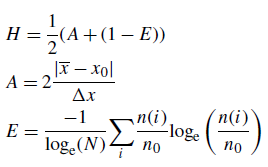

In [ ]:
h_t = compute_h(ds, "time").rename("H_T")
h_t.plot()

In [ ]:
ds_masked = ds.where(h_t > 0.5)
h_s = 0.5 * (
    compute_h(ds_masked, "latitude") + compute_h(ds_masked, "longitude")
).rename("H_S")
h_s.plot()
plt.grid()

In [ ]:
h_s_lim = h_s.quantile(0.5).values + 2 * h_s.std().values
mask = (h_s <= h_s_lim).compute()
mask.plot(marker=".", ls="none")
plt.grid()

## Compute growth rate

In [ ]:
ds = ds.where(mask)
dataarrays = []
for zonal_first in [False, True]:
    da = compute_growth_rate(ds, zonal_first=zonal_first)
    dataarrays.append(
        da.expand_dims(method=["Zonal-first" if zonal_first else "Standard"])
    )
da = xr.concat(dataarrays, "method").sel(time=slice(str(year_start), str(year_stop)))
da = da.sel(latitude=lat_slice)

## Plot monthly growth rate

In [ ]:
facet = da.plot(col="latitude", col_wrap=3, hue="method")
for ax, sel_dict in zip(facet.axs.flatten(), facet.name_dicts.flatten()):
    ax.grid()
    ax.set_title(band_from_central_latitude(sel_dict["latitude"]))
    for label in ax.get_xticklabels():
        label.set_rotation(90)

## Plot bars

In [ ]:
fig, axs = plt.subplots(
    da.sizes["latitude"],
    1,
    figsize=(15, da.sizes["latitude"] * 3),
    sharex=True,
    sharey=True,
)
da_resampled = da.resample(time="1MS").mean()
mask = (da_resampled["time"].dt.month == 1) & (da_resampled["time"].dt.day == 1)
xticks = xr.DataArray(range(da_resampled.sizes["time"]), dims="time").where(
    mask, drop=True
)
labels = da_resampled["time"].isel(time=mask).dt.year
for ax, (lat, da_lat) in zip(axs.flatten(), da_resampled.groupby("latitude")):
    da_lat.squeeze().to_pandas().T.plot.bar(ax=ax)
    ax.set_xticks(xticks.values, labels=labels.values)
    ax.grid()
    ax.set_xlabel("time")
    ax.set_ylabel(f"{da_lat.long_name} [{da_lat.units}]")
    ax.set_title(band_from_central_latitude(lat))
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

## Heat map

In [ ]:
with xr.set_options(keep_attrs=True):
    anomaly = da - spatial_weighted_mean(da)
anomaly.attrs["long_name"] = "Δ" + anomaly.long_name
yticks = anomaly["latitude"].values.tolist()
facet = anomaly.plot(
    row="method", robust=True, x="time", figsize=(10, 10), yticks=yticks
)
for ax in facet.axs.flatten():
    ax.grid()
    ax.set_yticklabels([band_from_central_latitude(lat) for lat in ax.get_yticks()])

## Plot yearly mean growth rate

In [ ]:
grouped = da.groupby("time.year")
da_mean = grouped.map(spatial_weighted_mean, dim=["time", "latitude"])
da_std = grouped.map(spatial_weighted_std, dim=["time", "latitude"])
df_mean = da_mean.to_pandas().T
df_std = da_std.to_pandas().T
ax = df_mean.plot.bar(yerr=df_std)
ax.grid()
_ = ax.set_ylabel(f"{da_mean.long_name} [{da_mean.units}]")